In [55]:
import sys
sys.path.append('../')

import graph.random_graph as random_graph
import util.create_population as create_population

import torch
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"



In [56]:
def sim(timeHorizon, model: pure_EPI_dense, state):
  populationNumber= []
  states = [state]
  for _ in range(timeHorizon):
    state= model(state)
    populationNumber.append(model.get_population_num(state))
    states.append(state)
  populationNumber = torch.stack(populationNumber)
  states = torch.stack(states)
  return populationNumber, states

In [67]:
n= 1000
avgDegree= 4
timeHorizon= 5
print("haha")
contact=random_graph.get_ER_random_contact(n, avgDegree, device=device)
print("haha")
contact = contact.requires_grad_(True)
ps=     torch.tensor([[0, 0.3, 0, 0],
                      [0, 0, 0.5, 0],
                      [0, 0, 0, 0.2],
                      [0, 0, 0, 0]], device=device)
state= create_population.population(n, device)
state= torch.stack([state, state])
model=pure_EPI_dense(contact, ps, device=device, sampleAsState= False)

haha
haha


In [68]:
realNumber, _= sim(50, model=model, state=state)
realNumber= realNumber[:, 0, :]

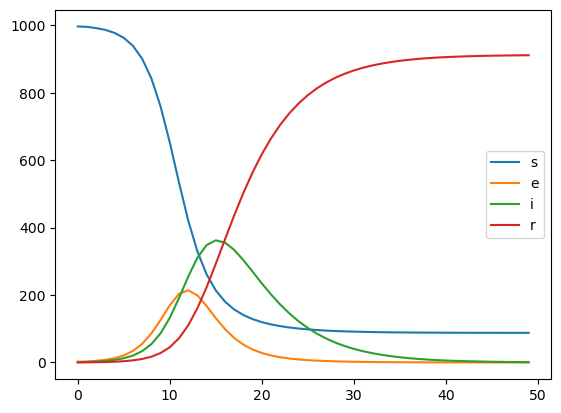

In [69]:
plotRealNumber= realNumber.squeeze().cpu().detach()
plt.plot(plotRealNumber, label=["s", "e", "i", "r"])
plt.legend()